# Calculate frictional slopes

Copyright 2020 Marco A. Lopez-Sanchez

Mozilla Public License 2.0: https://www.mozilla.org/en-US/MPL/2.0/

> **Goal of the notebook**: Understand the basics of brittle deformation and calculate frictional slopes. The Coulomb fracture criterion, Byerlees's and Amonton's laws, the Hubbert-Rubey fluid-pressure hypothesis, and the Anderson's theory will be introduced.

In [3]:
# import the required Python scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set a custom figure style (optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'ffffff'
mpl.rcParams['axes.facecolor'] = 'ffffff'
mpl.rcParams['axes.edgecolor'] = 'ffffff'

## The Anderson model

TODO

Anderson (1951) made two assumptions:
- simplified the types of faults in three different cases (normal, inverse, and strike-slip)
- assumed that two main stresses are parallel to the earth's surface (and therefore the remaining one perpendicular to it)

Then, he recalculated the Coulomb fracture criterion in terms of differential stress $(\sigma_1 - \sigma_3 = \sigma_d)$ and lithostatic stress (or pressure) $(\sigma_L = \rho gh)$. In this case, the lithostatic stress for the three different cases will be
- $\sigma_L = \sigma_1$ (normal),
- $\sigma_L = \sigma_3$ (inverse),
- $\sigma_L = \sigma_2 = 0.5(\sigma_1 + \sigma_3)$ (strike-slip).

to finally obtain

Inverse fault
$\sigma_d = \frac{2(\sigma_0 + \mu \sigma_L (1 - \lambda))}{\sqrt{\mu^2 + 1}-\mu}$

Strike-slip fault
$\sigma_d = \frac{2(\sigma_0 + \mu \sigma_L (1 - \lambda))}{\sqrt{\mu^2 + 1}}$

Normal (extensional) fault
$\sigma_d = \frac{-2(\sigma_0 - \mu \sigma_L (1 - \lambda))}{\sqrt{\mu^2 + 1}+\mu}$

TODO

In [14]:
def Anderson_fault(fault_type, depths, pressure, mu=0.73, lamb=0.36, C0=0.0):
    """ Returns the corresponding differential stress in MPa for a specific depth
    based on the Anderson theory of faulting (Anderson, 1905) and the Coulomb–
    Navier’s law of friction.

    Parameters
    ----------
    fault_type : string
        the type of fault, either 'inverse', 'normal' or 'strike-slip'
    depths : array-like
        an array-like with the depths [km]
    pressure : array-like
        the lithostatic stress of pressure at different depths [GPa]
    mu : scalar between 0 and 1, optional
        Coefficient of friction. Default value 0.73; this is the Rutter
        and Glover (2012) coefficient recalculated from Byerlee (1978) data
    lamb : scalar between 0 and 1, optional
        Hubbert-Rubbey coefficient of fluid pressure. Zero is for dry conditions.
        Default = 0.36
    C0 : positive scalar, optional
        Internal cohesion of the rock [MPa]. Mostly negligible in nature, default
        is zero. Alternatively, this parameter can be used as the frictional
        cohesive strenght as well.
    """

    depths = depths * 1000  # convert km to m
    pressure = pressure * 1e9  # convert GPa to Pa

    if fault_type == 'inverse':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) - mu)

    elif fault_type == 'strike-slip':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1))

    elif fault_type == 'normal':
        diff_stress = (- 2 * (C0 - mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) + mu)

    return diff_stress / 10**6

## First example

To start simple, let's estimate at which differential stress brittle failure occurs as a function of lithostatic pressure and the type of fault. For this, let's assume that the internal cohesion of the rock is null (_Amonton's law_), that the coefficient of friction is that of the _Byerlee's law_ $\mu = 0.85$, and that the rocks are completely dry (i.e. coefficient of fluid pressure equals 0). We also assume that the rock density is similar to the first 15 km of the crust.

In [15]:
# set the required parameters 
ro_crust = 2750  # average rock density in the crust [kg/m**3]
g = 9.80665      # average gravitational acceleration [m/s**2]

# generate a linear spaced array of depths every 10 m from 0 to 15 km depth
depths = np.linspace(start=0, stop=15, num=1500)

# create a spreadsheet (DataFrame) containing the depths and corresponding lithostatic stresses
data = pd.DataFrame({
    'depths': depths,
    'pressure': (ro_crust * g * depths) / 1e6})  # / 1e6 to obtain GPa
data

,depths,pressure
0,0.000000,0.000000
1,0.010007,0.000270
2,0.020013,0.000540
3,0.030020,0.000810
4,0.040027,0.001079
...,...,...
1495,14.959973,0.403445
1496,14.969980,0.403715
1497,14.979987,0.403985
1498,14.989993,0.404254


In [16]:
data['thrust'] = Anderson_fault('inverse',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['normal'] = Anderson_fault('normal',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['strike'] = Anderson_fault('strike-slip',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)
data

,depths,pressure,thrust,normal,strike
0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.010007,0.000270,0.992056,0.212152,0.349552
2,0.020013,0.000540,1.984111,0.424305,0.699105
3,0.030020,0.000810,2.976167,0.636457,1.048657
4,0.040027,0.001079,3.968223,0.848609,1.398210
...,...,...,...,...,...
1495,14.959973,0.403445,1483.123346,317.167697,522.580854
1496,14.969980,0.403715,1484.115402,317.379849,522.930407
1497,14.979987,0.403985,1485.107457,317.592001,523.279959
1498,14.989993,0.404254,1486.099513,317.804153,523.629511


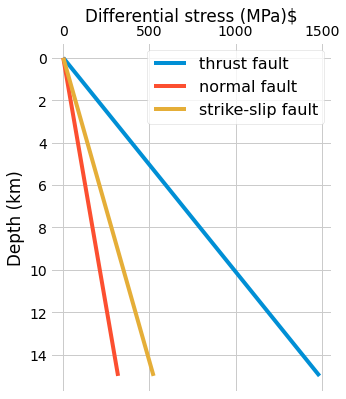

In [19]:
# plot the geotherm for the entire lithosphere
fig, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

ax.plot(data['thrust'], data['depths'], label='thrust fault')
ax.plot(data['normal'], data['depths'], label='normal fault')
ax.plot(data['strike'], data['depths'], label='strike-slip fault')

ax.set(xlabel='Differential stress (MPa)$', ylabel='Depth (km)')
ax.legend(loc='best', fontsize=16)